
<style>
    .title_div {
    padding: 60px;
    text-align: center;
    background: #ffffff;
    }
    #title {
        color: #f2a900;
        font-size: 80px;
    }
    #subtitle {
        color: #4d4d4e;
        font-size: 20px;
    }
</style>

<div class="title_div">
  <h1 id="title">HD Wallet</h1>
  <p id="subtitle">Hierarchical Deterministic Wallet</p>
</div>

## TOC:
* [Mnemonic Seed](#mneumonic-seed)
    * [Entropy](#entropy)
    * [Mnemonic creation](#mnemonic-create)
    * [Seeding](#seeding)
    * [Validation](#validation)
        * [Mnemonic validation](#mnemonic-validation)
        * [Seed validation](#seed-validation)
* [Extended Keys](#extended-keys)
    * [Master Extended Keys](#master-extended-keys)
    * [Key derivation](#key-derivation)
        * [Normal child extended private key](#normal-child-private)
        * [Hardened child extended private key](#hardened-child-private)
        * [Normal child extended public key](#normal-child-public)
        * [Hardened child extended public key](#hardened-child-public)
    * [Key derivation paths](#derivation-paths)
    * [Two parties key derivation test](#two-parties)
* [Encodings](#encodings)
    * [Extended key serialization](#extended-serialization)
    * [WIF](#wif)
    * [Addresses](#addreses)
* [Our HD-Wallet](#our-wallet)
* [From address to QR code](#QRcode)
    

In [61]:
from cryptography.hazmat.primitives.serialization import Encoding, PublicFormat, PrivateFormat
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import hashes, hmac
from cryptography.hazmat import primitives


from ecpy.curves import Curve, Point # for elliptic curve math
from bitarray import bitarray, util 
from secrets import token_bytes # secure random source

import hashlib # mainly for RMD160 hash
import base58 # base 58 encoding

# QR codes
import pyqrcode
from IPython.display import SVG
import io

# Mneumonic seed <a class="anchor" id="mneumonic-seed"></a>

## Entropy <a clas="anchor" id="entropy"></a>
Generate a blob between 128 and 256 bits from a secure random source.
The length of the entropy should be multiple of 32.

In [62]:
def entropy_gen(n = 128):
    if n < 128 or n > 256:
        raise Exception("Entropy size must be between 128 and 256 bits inclusive.")
    if n % 32 != 0:
        raise Exception("Entropy size must be multiple of 32.")
    return token_bytes(n // 8)

entropy = entropy_gen(32*8)
print(f"Entropy (hex): {entropy.hex()}") #256 bits

Entropy (hex): 5acbc63637d6161af8db6f27e4f0adea44d4257eefc893b138dbe5de50935dac


## Mnemonic creation <a class="anchor" id="mnemonic-create"></a>

To make the entropy more human friendly we conver it to a series or words and introduce some error checking. To do so in this case we are gonna make use of __[BIP39-english](https://raw.githubusercontent.com/otromimi/bitcoin_testpad/wallet/BIP-0039_english.txt)__.

<div style="color:orange">
<h3>Atention</h3>
Mnemonic phrases are suported in many lenguages and alphabets. This notebook only uses the english ASCII variant.</br>
For other alphabets use UTF-8 NFKD encoding.
</div>

In [63]:
colors = {'red':'\033[91m', 'green':'\033[92m', 'yellow':'\033[93m', 'blue':'\033[94m', 'purple':'\033[95m', 'cian':'\033[96m', 'gray':'\033[90m'}

def mnemonic(bits):
    # Entorpy 2 binary
    entropy_bits = bitarray()
    entropy_bits.frombytes(bits)
    
    # Checksum
    hash256 = hashes.Hash(hashes.SHA256())
    hash256.update(bits)
    bin_h = bitarray()
    bin_h.frombytes(hash256.finalize())
    
    entropy_bits = entropy_bits + bin_h[:(len(entropy_bits) // 32)]

    numbers = [] # words numbers
    for i in range(len(entropy_bits)//11):
        numbers.append(util.ba2int(entropy_bits[11*i:11*i+11]))

    words = {} # words in our entropy
    with open('BIP-0039_english.txt', 'r') as file:
        for i, word in enumerate(file):
            if i in numbers:
                words[i] = word
                if len(numbers) == len(words):
                    break
    
    mnemonic_sentence = [] # mneumonic
    for i in numbers:
        mnemonic_sentence.append(words[i].strip()) 
    
    return tuple(mnemonic_sentence)


# change this assigment to check for different values.
entropy = entropy # Ex: entropy = entropy_gen()

mnemonic_sentence = " ".join(mnemonic(entropy))

# Entropy binary
entropy_bits = bitarray()
entropy_bits.frombytes(entropy)

# Entropy hash
hash256 = hashes.Hash(hashes.SHA256())
hash256.update(entropy)
bin_h = bitarray()
entropy_hash = hash256.finalize()
bin_h.frombytes(entropy_hash)

# Printing
if True:
    print(colors['purple']+entropy_bits.to01(), end="")
    print(colors['yellow']+bin_h.to01()[:(len(entropy_bits) // 32)], end="\n")
    print(f"{colors['purple']}\u2589 {'Entropy'}")
    print(f"{colors['yellow']}\u2589 {'Checksum (hash)'}\033[0m\n")

    print(f"Entropy (hex): {entropy.hex()}")
    print(f"entropy SHA-256: {entropy_hash.hex()}")

    print("\n\u250F"+"\u2501"*(len(mnemonic_sentence)+2)+"\u2513")
    print("\u2503 "+mnemonic_sentence+" \u2503")
    print("\u2517"+"\u2501"*(len(mnemonic_sentence)+2)+"\u251B")

del entropy_bits, hash256, bin_h, entropy_hash


010110101100101111000110001101100011011111010110000101100001101011111000110110110110111100100111111001001111000010101101111010100100010011010100001001010111111011101111110010001001001110110001001110001101101111100101110111100101000010010011010111011010110011001010
▉ Entropy
▉ Checksum (hash)

Entropy (hex): 5acbc63637d6161af8db6f27e4f0adea44d4257eefc893b138dbe5de50935dac
entropy SHA-256: caf5997e99035674ef05f0c217b9fe3df363f14839fb95877c11e4b1b0e15787

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ food funny mirror hurry gesture aspect toddler hospital child chest clock stand essence bargain wing weekend neck mean dad slight topic endless issue off ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


## Seeding<a class="anchor" id="seeding"></a>
Derivates the seed that will be use for creating our cryptographic keys. We achive this by using an algorithm computer intensive that will slow down an attack.

Algorithm used: PBKDF2_HMAC (Password Based Key Derivation Function 2)<br>
* Hashing function: SHA-512 HMAC<br>
* Iterations: 2048<br>
* length: resulting key (seed) lenght in bytes<br>

Thanks to the use of a HMAC (Hash Message Authentication Code) hash function we can add a salt (password) to our nmonic phrase.



In [64]:
def mnemonic2seed(mnemonic_sentence, salt=""):
    
    mnemonic_dev = PBKDF2HMAC(
        algorithm = hashes.SHA512(),
        length = 64, #bytes
        salt = ("mnemonic"+salt).encode('ascii'),
        iterations = 2048
    )

    mnemonic_bytes = mnemonic_sentence.encode('ascii')
    seed = mnemonic_dev.derive(mnemonic_bytes)

    return seed


recovery_pass = "" # In case we want to add a salt to our mneumonic, add in here

seed = mnemonic2seed(mnemonic_sentence, recovery_pass)

if recovery_pass:
    print(f"Recovery password: {colors['red']}{recovery_pass}\033[0m")
print(f"Seed: {seed.hex()}")


Seed: 2e1d0690666476a799ba30b318e6609df9b151e1ac71987aaf0ccce3cb75d8378204da07cb08af4e67adb5bf66b2123b29288c0c551dffcb089cd7d1b03f3162


## Validation<a class="anchor" id="validation"></a>

### Mnemonic validation<a class="anchor" id="mnemonic-validation"></a>
Validates de entropy against its hash to determinate if the mnemonic secuence was correct.

Requires: __[BIP39-english](https://raw.githubusercontent.com/otromimi/bitcoin_testpad/wallet/BIP-0039_english.txt)__.

In [65]:
def mnemonic_check(mnemonic):

    words = mnemonic.split(" ")
    numbers = [None] * len(words)

    with open('BIP-0039_english.txt') as file:
        for i, word in enumerate(file):
            if word.strip() in words:
                for j, item in enumerate(words):
                    if item == word.strip():
                        numbers[j] = i
    
    entropy = "".join([f'{i:011b}' for i in numbers])
    entropy = bitarray(entropy)

    checksum_len = len(entropy) % 32

    hash256 = hashes.Hash(hashes.SHA256())
    hash256.update(entropy[:-checksum_len].tobytes())
    bin_h = bitarray()
    entropy_hash = hash256.finalize()
    bin_h.frombytes(entropy_hash)
    
    if entropy[-checksum_len:] != bin_h[:checksum_len]:
        # Just raised in case checksum for mneumonic fails.
        raise Exception(f"Checksum fail, hash: {entropy_hash.hex()}")
    
    return entropy[:-checksum_len].tobytes()



recover_entropy = mnemonic_check(mnemonic_sentence)

print(f"{entropy.hex()} -> entropy") # entropy generated on first cell
print(f"{recover_entropy.hex()} -> recovered entropy")

del recover_entropy


5acbc63637d6161af8db6f27e4f0adea44d4257eefc893b138dbe5de50935dac -> entropy
5acbc63637d6161af8db6f27e4f0adea44d4257eefc893b138dbe5de50935dac -> recovered entropy


### Seed validation<a class="anchor" id="seed-validation"></a>

Validates the seed against the entropy and password.

In [66]:
def seed_check(seed, password):

    seed_chk = PBKDF2HMAC(
        algorithm = hashes.SHA512(),
        length = 64,
        salt = ("mnemonic"+password).encode('ascii'),
        iterations = 2048
    )
    seed_chk.verify(mnemonic_sentence.encode('ascii'), seed) # in case validation fails will raise a exception

if not seed_check(seed, recovery_pass):
    print("Seed check passed. \u2705")

Seed check passed. ✅


***

# Extended keys <a class="anchor" id="extended-keys"></a>

* [Master Extended Keys](#master-extended-keys)
* [Key derivation](#key-derivation)
    * [Normal child extended private key](#normal-child-private)
    * [Hardened child extended private key](#hardened-child-private)
    * [Normal child extended public key](#normal-child-public)
    * [Hardened child extended public key](#hardened-child-public)
* [Key derivation paths](#derivation-paths)
* [Two parties key derivation test](#two-parties)

## Master Extended Keys <a class="anchor" id="master-extended-keys"></a>


In [67]:
def master_key_extended(seed):

    expression = "Bitcoin seed" # Used for master key

    hmac_master = hmac.HMAC(expression.encode('ascii'), hashes.SHA512())
    hmac_master.update(seed)
    output = hmac_master.finalize()

    secret_num = output[:32]
    chain_code = output[32:]

    return ('m', secret_num, chain_code)


_, prv_master_key, chain_master_code = master_key_extended(seed)

private_key = ec.derive_private_key(int.from_bytes(prv_master_key, 'big'), ec.SECP256K1())
public_key = private_key.public_key()
pub_master_key = public_key.public_bytes(Encoding.X962, PublicFormat.CompressedPoint)


print(f"Chain code: {chain_master_code.hex()}")
print(f"Private master key (d): {prv_master_key.hex()}")
print(f"Public master key (compressed): {pub_master_key.hex()}")

del private_key, public_key

Chain code: 2e062c969cac11867b5ec7bf64aedd2468e24dd26890bb3155f3232e98e381f7
Private master key (d): 04103b4b251581b45e8add6c9c3645a4706d819e44463d74c07587ab32b44b0b
Public master key (compressed): 022b01b955fb902bab52c810fc980039a94f75031f25d758997586b1588ac675ee



## Key derivation<a class="anchor" id="key-derivation"></a>

1. [Normal child extended private key](#normal-child-private)
2. [Hardened child extended private key](#hardened-child-private)
3. [Normal child extended public key](#normal-child-public)
4. [Hardened child extended public key](#hardened-child-public)

In [68]:
def key_derivation(index, parent_key, parent_chain_code):

    index_bytes = index.to_bytes(32 // 8, 'big')
    data = parent_key + index_bytes
    salt = parent_chain_code

    hmac_512 = hmac.HMAC(salt, hashes.SHA512())
    hmac_512.update(data)
    output = hmac_512.finalize()

    return (output[:32], output[32:])

### Normal child extended private key<a class="anchor" id="normal-child-private"></a>

In [69]:
def private_normal_child(index, parent_prv_key, parent_chain_code):
    cv = Curve.get_curve('secp256k1')

    # Order of SECP256K1
    n = cv.order

    # Index range checking
    if index > 2147483647 | index < 0:
        raise f"Index: {index}, out of range for soft derivation."
    
    # Generating public key
    private_key = ec.derive_private_key(int.from_bytes(parent_prv_key, 'big'), ec.SECP256K1())
    public_key = private_key.public_key()
    parent_pub_key = public_key.public_bytes(Encoding.X962, PublicFormat.CompressedPoint)

    # Derivation function
    child_prv_key, child_chain_code = key_derivation(index, parent_pub_key, parent_chain_code)

    # Checking child_chain_code
    if int.from_bytes(child_chain_code, 'big') > n:
        raise f"Chain code bigger than curve order \"n\"; Try with index {index + 1}"
    
    # Calculating child private key
    child_prv_key = ((int.from_bytes(child_prv_key, 'big') + int.from_bytes(parent_prv_key, 'big')) % n).to_bytes(32, 'big')

    return (index, child_prv_key, child_chain_code)




index, key, chain_code = private_normal_child(0, prv_master_key, chain_master_code)

private_key = ec.derive_private_key(int.from_bytes(key, 'big'), ec.SECP256K1())
public_key = private_key.public_key()
public_compress_child = public_key.public_bytes(Encoding.X962, PublicFormat.CompressedPoint)

print(f"Index: {index}")
print(f"Chain code: {chain_code.hex()}")
print(f"Private key (d): {key.hex()}")
print(f"Public key (compressed): {public_compress_child.hex()}")

del index, key, chain_code, private_key, public_key, public_compress_child

Index: 0
Chain code: cb69c71adc479837f54265647583eac2db3243191ae4cc337aac4a9bd1b230db
Private key (d): 7ffe88f9e63e25eebc6246a415b468940237f5531d4258687862d43f96cf5730
Public key (compressed): 029e6ac788133b1084ed18446ceff11390b3213af8e532902cba2ecb1f2149235b


### Hardened child extended private key<a class="anchor" id="hardened-child-private"></a>

In [70]:
def private_hardened_child(index, parent_prv_key, parent_chain_code):
    cv = Curve.get_curve('secp256k1')

    # Order of SECP256K1
    n = cv.order

    # Index range checking
    if index > 2147483647 | index < 0:
        raise f"Index: {index}, Hard index: {index + 2147483648}, out of range for hard derivation."
    
    # Generating public key --> No required

    # Derivation function
    child_prv_key, child_chain_code = key_derivation(
        index + 2147483648, # Hard index range
        b'\x00' + parent_prv_key, # Leading bit for public key compensation
        parent_chain_code
    )

    # Checking child_chain_code
    if int.from_bytes(child_chain_code, 'big') > n:
        raise f"Chain code bigger than curve order \"n\"; Try with index {index + 1}"
    
    # Calculating child private key
    child_prv_key = ((int.from_bytes(child_prv_key, 'big') + int.from_bytes(parent_prv_key, 'big')) % n).to_bytes(32, 'big')

    return (index, child_prv_key, child_chain_code)




index, key, chain_code = private_hardened_child(0, prv_master_key, chain_master_code)

private_key = ec.derive_private_key(int.from_bytes(key, 'big'), ec.SECP256K1())
public_key = private_key.public_key()
public_compress_child = public_key.public_bytes(Encoding.X962, PublicFormat.CompressedPoint)


print(f"Index: {index}, Hard index: {index + 2147483648}")
print(f"Chain code: {chain_code.hex()}")
print(f"Private key (d): {key.hex()}")
print(f"Public key (compressed): {public_compress_child.hex()}")

del index, key, chain_code, private_key, public_key, public_compress_child

Index: 0, Hard index: 2147483648
Chain code: 7e165467661db1a401ed6f0e648309f6cc5cf86963a8c96757558c8f736692dd
Private key (d): 362e955e788ac0d39ee05d9d9f9816c197ea0ce8a81512772adbdb7ae87e7ed3
Public key (compressed): 033f0b2626896af5f27851c76afb66c9140347c4f460168e16f684674e3bf7146a


### Normal child extended public key<a class="anchor" id="normal-child-public"></a>

In [71]:
def public_normal_child(index, parent_pub_key, parent_chain_code):
    cv = Curve.get_curve('secp256k1')

    # Order of SECP256K1
    n = cv.order

    # Index range checking
    if index > 2147483647 | index < 0:
        raise f"Index: {index}, out of range for soft derivation."
    
    # Generating public key --> No required, we pass the pub key as parameter

    # Derivation function
    child_pub_key, child_chain_code = key_derivation(index, parent_pub_key, parent_chain_code)

    # Checking child_chain_code
    if int.from_bytes(child_chain_code, 'big') > n:
        raise f"Chain code bigger than curve order \"n\"; Try with index {index + 1}"

    # Calculating child private key
    parent_point = cv.decode_point(parent_pub_key)
    child_point = cv.mul_point(int.from_bytes(child_pub_key, 'big'), cv.generator)
    result_point = parent_point + child_point

    # Encoding in weird format because ECPy doesn't support compress point encoding
    child_pub_key = ec.EllipticCurvePublicKey.from_encoded_point(
        ec.SECP256K1(), 
        bytes(cv.encode_point(result_point))).public_bytes(
            Encoding.X962, 
            PublicFormat.CompressedPoint
        )
    
    return (index, child_pub_key, child_chain_code)




index, key, chain_code = public_normal_child(0, pub_master_key, chain_master_code)

print(f"Index: {index}")
print(f"Chain code: {chain_code.hex()}")
print(f"Parent public key (compressed): {pub_master_key.hex()}")
print(f"Public key (compressed): {key.hex()}")

del index, key, chain_code

Index: 0
Chain code: cb69c71adc479837f54265647583eac2db3243191ae4cc337aac4a9bd1b230db
Parent public key (compressed): 022b01b955fb902bab52c810fc980039a94f75031f25d758997586b1588ac675ee
Public key (compressed): 029e6ac788133b1084ed18446ceff11390b3213af8e532902cba2ecb1f2149235b


### Hardened child extended public key<a class="anchor" id="hardened-child-public"></a>

In [72]:
def public_hardened_child(index, parent_pub_key, parent_chain_code):
    raise f"You need the private key to derive its peer public key."


## Key derivation paths <a class="anchor" id="derivation-paths"></a>

In [73]:
def derive_path(path, seed):
    path_list = path.split('/')
    index, key, chain_code = None, None, None
    for term in path_list:
        if term == 'm':
            # Master extended key from seed
            _, key, chain_code = master_key_extended(seed)
            continue
        if "'" in term:
            # Case term is hard
            _, key, chain_code = private_hardened_child(int(term.strip("'")), key, chain_code)
        else:
            # Case the term is soft of normal
            _, key, chain_code = private_normal_child(int(term), key, chain_code)
    return key, chain_code

derivation_path = "m/44'/0'/0'/0/0" # Path extipulated on BIP 44

path_key, _ = derive_path(derivation_path, seed)

print(f"Private key on {derivation_path}:\n\t{path_key.hex()}")

del derivation_path, path_key

Private key on m/44'/0'/0'/0/0:
	319d49ecc0849405689a442453851c14a7f7ed94fe6a6729aa122e4406bca48f


## Two parties key derivation test <a class="anchor" id="two-parties"></a>

For this test we are gonna derive in parallel the public and private key; and then sign and verify a message with those keys independently derived.

In [74]:
# Finding the master pub, prv and chain-code
prv_secret, chain_code_m = derive_path("m", seed)
prv_key_m = ec.derive_private_key(int.from_bytes(prv_secret, 'big'), ec.SECP256K1())
pub_key_m = prv_key_m.public_key().public_bytes(Encoding.X962, PublicFormat.CompressedPoint)

# Derive our path for our private key
prv_secret, _ = derive_path("m/444/8", seed) # paths must be the same
prv_key = ec.derive_private_key(int.from_bytes(prv_secret, 'big'), ec.SECP256K1())

# We derive the same path for our public key
_, pub_key, chain_code_child = public_normal_child(444, pub_key_m, chain_code_m) # 444/
_, pub_key, chain_code_child = public_normal_child(8, pub_key, chain_code_child) # 8/
pub_key = ec.EllipticCurvePublicKey.from_encoded_point(ec.SECP256K1(), pub_key)

# We sign a message with our derived private key
message = b"Testing derivaiton of extended keys."
signature = prv_key.sign(message, ec.ECDSA(hashes.SHA256()))

# If no exception raised then the signature is correct
pub_key.verify(signature, message, ec.ECDSA(hashes.SHA256()))


del prv_secret, prv_key_m, pub_key_m, prv_key, pub_key, message, signature, \
    chain_code_child, chain_code_m

***

# Encodings <a class="anchor" id="encodings"></a>

* [Extended key serialization](#extended-serialization)
* [WIF](#wif)
* [Addresses](#addreses)

## Extended key serialization <a class="anchor" id="extended-serialization"></a>

version + depth + fingerprint + childnumber + chain_code + key + (checksum)

* version:     puts xprv or xpub at the start
* depth:       how many times this child has been derived from master key (0 = master key)
* fingerprint: created from parent public key (allows you to spot adjacent xprv and xpubs)
* childnumber: the index of this child key from the parent
* chain_code:  the current chain code being used for this key
* key:         the private or public key you want to create a serialized extended key for (prepend 0x00 for private)

In [75]:
def extended_serialization(depth, parent_key, child_number, chain_code, key, version = None, testnet = True):

    # Version BIP 44
    if version == None and testnet == False:
        serialized_key = b"\x04\x88\xad\xe4" if len(key) == 32 else b"\x04\x88\xb2\x1e"
    elif version == None and testnet == True:
        serialized_key = b"\x04\x35\x83\x94" if len(key) == 32 else b"\x04\x35\x87\xcf"
    else:
        serialized_key = verison
   
    # Depth
    serialized_key += depth.to_bytes(1, 'big')

    # Fingerpirnt of the pub father key
    hash1 = hashlib.sha256(parent_key)
    hash2 = hashlib.new('rmd160')
    hash2.update(hash1.digest())
    fingerprint = hash2.digest()[:4]

    # Child index
    index = child_number.to_bytes(4, 'big')

    serialized_key += fingerprint + index + chain_code

    # If pvt key prepend 0x00
    if len(key) == 32:
        serialized_key += b"\x00"

    serialized_key += key

    # Checksum
    hash1 = hashlib.sha256(serialized_key)
    hash2 = hashlib.sha256(hash1.digest())

    serialized_key += hash2.digest()[:4]

    return base58.b58encode(serialized_key)


# Derivaiton paths
derivation_path = "m/0" #44'/0'/0'/0/0
parent_derivation_path = "/".join(derivation_path.split('/')[:-1])

# Generating necesary keys
prv_key, chain_code = derive_path(derivation_path, seed)
parent_prv_key, _ = derive_path(parent_derivation_path, seed)
parent_prv_key = ec.derive_private_key(int.from_bytes(parent_prv_key, 'big'), ec.SECP256K1())
parent_pub_key = parent_prv_key.public_key().public_bytes(Encoding.X962, PublicFormat.CompressedPoint)

# Getting index and depth
derivation_count = len(derivation_path.split('/'))-1
child_n = int(derivation_path.split('/')[-1].strip("'"))

# Serialization
serialized_key = extended_serialization(derivation_count, parent_pub_key, child_n, chain_code, prv_key)

# Printing
if True:
    print(f"Parent derivation path: {parent_derivation_path}")
    print(f"Parent public key: {parent_pub_key.hex()}\n")

    print(f"Derivation path: {derivation_path}")
    print(f"Key: {prv_key.hex()}")
    print(f"Chain code: {chain_code.hex()}\n")

    print(colors['red']+base58.b58decode(serialized_key).hex()[0:8], end="")
    print(colors['blue']+base58.b58decode(serialized_key).hex()[8:10], end="")
    print(colors['purple']+base58.b58decode(serialized_key).hex()[10:18], end="")
    print(colors['cian']+base58.b58decode(serialized_key).hex()[18:26], end="")
    print(colors['yellow']+base58.b58decode(serialized_key).hex()[26:90], end="")
    print(colors['green']+base58.b58decode(serialized_key).hex()[90:156], end="")
    print(colors['gray']+base58.b58decode(serialized_key).hex()[156:], end="\n")

    print(f"{colors['red']}\u2589 {'Version'}", end="\t")
    print(f"{colors['blue']}\u2589 {'Depth'}")
    print(f"{colors['purple']}\u2589 {'Fingerprint'}", end="\t")
    print(f"{colors['cian']}\u2589 {'Child index'}")
    print(f"{colors['yellow']}\u2589 {'Chain code'}", end="\t")
    print(f"{colors['green']}\u2589 {'Key'}")
    print(f"{colors['gray']}\u2589 {'Checksum'}", end="\033[0m\n")

    print("\n\u250F"+"\u2501"*(len(serialized_key.decode('ascii'))+2)+"\u2513")
    print("\u2503 "+serialized_key.decode('ascii')+" \u2503")
    print("\u2517"+"\u2501"*(len(serialized_key.decode('ascii'))+2)+"\u251B")

del prv_key, chain_code, parent_prv_key, parent_pub_key, derivation_path, \
    parent_derivation_path, derivation_count, child_n, serialized_key

Parent derivation path: m
Parent public key: 022b01b955fb902bab52c810fc980039a94f75031f25d758997586b1588ac675ee

Derivation path: m/0
Key: 7ffe88f9e63e25eebc6246a415b468940237f5531d4258687862d43f96cf5730
Chain code: cb69c71adc479837f54265647583eac2db3243191ae4cc337aac4a9bd1b230db

043583940190216be300000000cb69c71adc479837f54265647583eac2db3243191ae4cc337aac4a9bd1b230db007ffe88f9e63e25eebc6246a415b468940237f5531d4258687862d43f96cf573033b8ce89
▉ Version	▉ Depth
▉ Fingerprint	▉ Child index
▉ Chain code	▉ Key
▉ Checksum

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ tprv8cdXypr3a2JZCyUyka4sW3rz3Xfk1QoG5hydhugLZxHYpDuuLxn7VM2YqHzdpc5EC4VztErcBkbjEXqmEHKspRn7GUbhJWtQWT9U9FpXpmN ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


## WIF (wallet import format)<a class="anchor" id="wif"></a>

A simple way to move private keys arround that contains the following fields in a human friendly base 54 encoding.
1. Network (mainet or testnet)
2. Private key (d)
3. Compress byte (denotates if pub keys are compressed)
4. Checksum

In [76]:
def wif(key, compressed = True, testnet = True):

    # Network
    network = b"\xef" if testnet else b"\x80"
    
    # Network + key + compress byte
    result = network + key + (b"\x01" if compressed else b"")
    
    # Checksum
    hash1 = hashlib.sha256(result)
    hash2 = hashlib.sha256(hash1.digest())
    result += hash2.digest()[0:4]

    return base58.b58encode(result)


wif_key = wif(prv_master_key)

# Prints
if True:
    print(colors['red']+base58.b58decode(wif_key).hex()[0:2], end="")
    print(colors['blue']+base58.b58decode(wif_key).hex()[2:66], end="")
    if len(base58.b58decode(wif_key).hex()) > 37 * 2:
        print(colors['yellow']+base58.b58decode(wif_key).hex()[66:68], end="")
        print(colors['purple']+base58.b58decode(wif_key).hex()[68:], end="\n")
    else:
        print(colors['purple']+base58.b58decode(wif_key).hex()[66:], end="\n")

    print(f"{colors['red']}\u2589 {'Network'}")
    print(f"{colors['blue']}\u2589 {'Key'}")
    print(f"{colors['yellow']}\u2589 {'Compress byte'}")
    print(f"{colors['purple']}\u2589 {'Checksum'}", end="\033[0m\n")

    print("\n\u250F"+"\u2501"*(len(wif_key.decode('ascii'))+2)+"\u2513")
    print("\u2503 "+wif_key.decode('ascii')+" \u2503")
    print("\u2517"+"\u2501"*(len(wif_key.decode('ascii'))+2)+"\u251B")

del wif_key

ef04103b4b251581b45e8add6c9c3645a4706d819e44463d74c07587ab32b44b0b0150a520b3
▉ Network
▉ Key
▉ Compress byte
▉ Checksum

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ cMibmti5aYJny8k52Eg8JZgmR6XJSsQHQUh6rXHuAL1eaK2f7sfY ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


## Addresses (P2PKH)<a class="anchor" id="addreses"></a>

Bitcoin addresses for P2PKH (Pay to public key hash).

In [77]:
def P2PKH(pub_key, testnet = True):
    # Network
    network = b"\x6f" if testnet else b"\x00"

    # hash160
    hash1 = hashlib.sha256(pub_key)
    hash2 = hashlib.new('rmd160')
    hash2.update(hash1.digest())
    result = network + hash2.digest()

    # Checksum
    hash1 = hashlib.sha256(result)
    hash2 = hashlib.sha256(hash1.digest())
    result += hash2.digest()[:4]

    return base58.b58encode(result)

address = P2PKH(pub_master_key, False)

# Prints
if True:
    print(colors['red']+base58.b58decode(address).hex()[0:2], end="")
    print(colors['blue']+base58.b58decode(address).hex()[2:-8], end="")
    print(colors['purple']+base58.b58decode(address).hex()[-8:], end="\n")

    print(f"{colors['red']}\u2589 {'Version'}")
    print(f"{colors['blue']}\u2589 {'hash160(pub_key)'}")
    print(f"{colors['purple']}\u2589 {'Checksum'}", end="\033[0m\n")

    print("\n\u250F"+"\u2501"*(len(address.decode('ascii'))+2)+"\u2513")
    print("\u2503 "+address.decode('ascii')+" \u2503")
    print("\u2517"+"\u2501"*(len(address.decode('ascii'))+2)+"\u251B")

del address

0090216be3db550cc1fe686901752ca736bf3281dd23b5575e
▉ Version
▉ hash160(pub_key)
▉ Checksum

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 1E96LncDBJcG1Kk5Zvh3WJRUMd88NS3ADb ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


***
# Our HD-Wallet <a class="anchor" id="our-wallet"></a>

In [99]:
if not 'mnemonic_sentence' in vars():
    entropy = entropy_gen(256)
    mnemonic_sentence = " ".join(mnemonic(entropy))

print("\n\u250F"+"\u2501"*(len(mnemonic_sentence)+2)+"\u2513")
print("\u2503 "+mnemonic_sentence+" \u2503")
print("\u2517"+"\u2501"*(len(mnemonic_sentence)+2)+"\u251B")

seed = mnemonic2seed(mnemonic_sentence)

def encoded_key_pairs(prv_key, chain_code, testnet = True):
    # WIF for private key
    wif_key = wif(prv_key, True, testnet)

    # Getting public key
    prv_key = ec.derive_private_key(int.from_bytes(prv_key, 'big'), ec.SECP256K1())
    pub_key = prv_key.public_key().public_bytes(Encoding.X962, PublicFormat.CompressedPoint)

    # Address from public key
    address = P2PKH(pub_key, testnet)
    
    return (wif_key, address)


derivation_path = "m/44'/1'/0'/0/0" # Path testnet BIP 44

recieve_addresses = []

if True:
    print("{:18}{:38}{:55}".format('Path'.center(18),'Address'.center(38),'WIF'.center(55)))
    print(colors['gray']+"-"*111, end='\033[0m\n')

    # Ordinary
    for i in range(10): # Wallets search on the first 20 addresses
        derivation = derivation_path.split('/')
        derivation[-1] = str(int(derivation_path[-1]) + i)

        extended_key = derive_path("/".join(derivation), seed)
        key_pair = encoded_key_pairs(*extended_key, True)

        print("{:>18}".format("/".join(derivation)), end="")
        print("{}{:>38}".format(colors['blue'], key_pair[1].decode('ascii')), end="")
        print("{}{:>55}".format(colors['red'], key_pair[0].decode('ascii')), end="\033[0m\n")
        recieve_addresses.append(key_pair[1].decode('ascii'))

    # Change
    for i in range(5):
        derivation = derivation_path.split('/')
        derivation[-2] = '1'
        derivation[-1] = str(int(derivation_path[-1]) + i)

        extended_key = derive_path("/".join(derivation), seed)
        key_pair = encoded_key_pairs(*extended_key, True)

        print("{:>18}".format("/".join(derivation)), end="")
        print("{}{:>38}".format(colors['yellow'], key_pair[1].decode('ascii')), end="")
        print("{}{:>55}".format(colors['red'], key_pair[0].decode('ascii')), end="\033[0m\n")
    
del derivation_path, extended_key, key_pair, derivation



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ april real maze beyond foam sail chat hub text adjust report trumpet tilt welcome brick reward naive annual filter essence alien tumble diamond piano ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
       Path                      Address                                          WIF                          
---------------------------------------------------------------------------------------------------------------
   m/44'/1'/0'/0/0    mzUfbS6kFE3XbUQv6a6dRfacDNLeBmageC   cQPmfwqZHZZg2oJoPX3stGmxXuanYvi57tZkcuK4tKfygMGy8hwQ
   m/44'/1'/0'/0/1    mtB1qTtUc9ZYhwvT1QEf8jnakoeHAv6Ymc   cU3CqhuUt8JdRKJredhk9BMTcSiMV7U3J5ncMgtkjdDwatamRvgp
   m/44'/1'/0'/0/2    n1UzVvJXXg8fiVzuiVzfg2N6W7K31qNtjK   cQFVrrvbM7R832TKTzZxt3qUwMN4nH

# From address to QR code <a class="anchor" id="QRcode"></a>

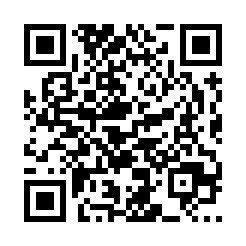

In [112]:
address = recieve_addresses[0] # Substitude for address to encode

QRCode = pyqrcode.create(address)
buffer = io.BytesIO()
QRCode.svg(buffer, scale=6)

SVG(buffer.getvalue())